## Examples of generated adversarial noise using ART and keras

In [1]:
import keras
from keras.models import load_model
from keras.datasets import mnist, fashion_mnist
from art.classifiers import KerasClassifier
from art.attacks.fast_gradient import FastGradientMethod
from art.attacks.iterative_method import BasicIterativeMethod
from art.attacks.deepfool import DeepFool
import numpy as np

Using TensorFlow backend.


### Load data and model

In [2]:
# uncomment for loading fashion mnist
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_test = np.expand_dims(x_test, axis=3)
# convert class vectors to binary class matrices
class_9 = np.where(y_test == 9)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

11493376/11490434 [==============================] - 5s 0us/step


In [42]:
# note that under models you can find for both datasets
classifier_model = load_model("models/mnist_cnn_original.h5")
classifier = KerasClassifier(classifier_model)

In [8]:
classifier_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

### Generate Adversarial samples for MNIST

In [38]:
attacker_fgm = FastGradientMethod(classifier, eps=0.01)
x_test_adv_fg = attacker_fgm.generate(x_test[8500:])

In [52]:
x_test[8500:].shape

(1500, 28, 28, 1)

In [15]:
attacker_df = DeepFool(classifier)
x_test_adv_df = attacker_df.generate(x_test[8500:]) # np.full((1500, 1), 0))

In [4]:
attacker_bim = BasicIterativeMethod(classifier, eps=0.01, max_iter=1000, eps_step=0.002)
x_test_adv_bim = attacker_bim.generate(x_test[8500:], y=[0]) # np.full((1500, 1), 0))

InvalidArgumentError: Expected size[0] in [0, 0], but got 1
	 [[{{node softmax_cross_entropy_with_logits_sg/Slice_1}} = Slice[Index=DT_INT32, T=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](softmax_cross_entropy_with_logits_sg/Shape_2, softmax_cross_entropy_with_logits_sg/Slice_2/size, softmax_cross_entropy_with_logits_sg/Slice_2/size)]]

In [48]:
attacker_bim = BasicIterativeMethod(classifier, eps=0.01, max_iter=1000, eps_step=0.002, targeted=True)
x_test_adv_bim = attacker_bim.generate(x_test[8500:], y=)

ValueError: Target labels `y` need to be provided for a targeted attack.

In [44]:
scores = classifier_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 125us/step
Test loss: 0.07132315555133055
Test accuracy: 0.9923


In [44]:
attacker_carlini = CarliniL2Method(classifier, confidence=0.0, targeted=False)
x_test_adv_cw = attacker_carlini.generate(x_test[8500:])

### Visualize adversarial samples

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

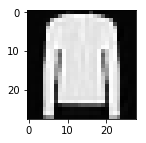

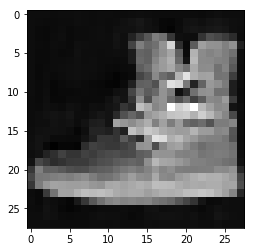

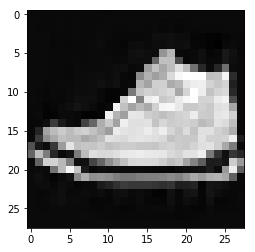

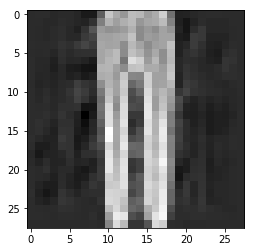

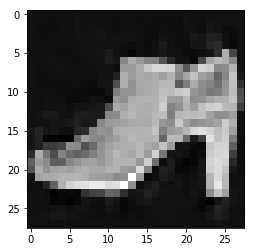

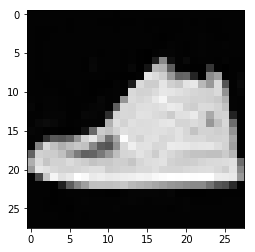

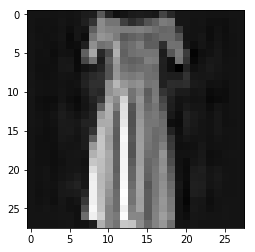

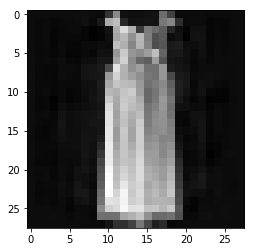

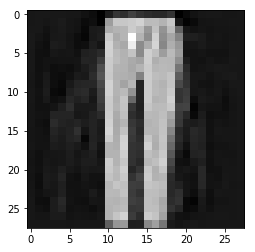

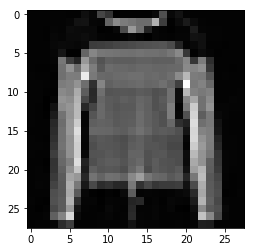

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(2, 2))
for i in range(10):
    plt.imshow(x_test_adv_df[i].reshape(28, 28), cmap='gray')
    plt.show()


#### BIM

In [49]:
with open('../ICLR/results/mnist_cleanbottleconv2d_4.out', 'r') as f:
    lines = f.readlines()
    score, precision, recall, len_image_sub, len_node_sub, optimal_alpha, node_subs, image_subs = lines[0].split(' ')

In [50]:
optimal_alpha

'0.00014283673760891302'

In [32]:
1./7001

0.00014283673760891302

In [43]:
images_ix = image_subs.split(',')
len([int(im) for im in images_ix])

725

In [46]:
images_ix

['1208',
 '192',
 '1098',
 '1178',
 '871',
 '457',
 '1194',
 '878',
 '1388',
 '486',
 '866',
 '868',
 '1276',
 '505',
 '245',
 '465',
 '929',
 '449',
 '814',
 '1114',
 '237',
 '1424',
 '266',
 '452',
 '926',
 '1182',
 '7',
 '12',
 '1023',
 '855',
 '420',
 '1249',
 '1389',
 '1255',
 '1228',
 '1016',
 '1221',
 '1015',
 '446',
 '1199',
 '1139',
 '1056',
 '1335',
 '469',
 '1425',
 '1280',
 '882',
 '1157',
 '919',
 '206',
 '593',
 '988',
 '687',
 '798',
 '1359',
 '872',
 '1116',
 '234',
 '846',
 '194',
 '259',
 '1476',
 '184',
 '953',
 '845',
 '902',
 '491',
 '1192',
 '603',
 '261',
 '1414',
 '1487',
 '941',
 '1251',
 '1330',
 '1394',
 '1197',
 '1212',
 '999',
 '231',
 '213',
 '874',
 '752',
 '777',
 '1172',
 '413',
 '1295',
 '913',
 '1225',
 '524',
 '1338',
 '971',
 '1163',
 '251',
 '789',
 '1143',
 '887',
 '933',
 '485',
 '433',
 '1365',
 '448',
 '1162',
 '805',
 '1329',
 '873',
 '13',
 '1264',
 '221',
 '1117',
 '987',
 '255',
 '430',
 '1111',
 '1496',
 '923',
 '1351',
 '1158',
 '412',
 '

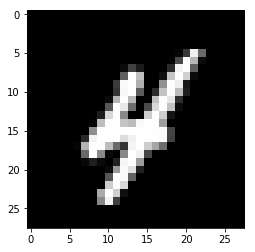

In [47]:
plt.imshow(clean[1208].reshape(28, 28), cmap='gray')

In [62]:
fgm = np.load('../ICLR/data/np_mnist_fgm_cnn_keras.npy') 

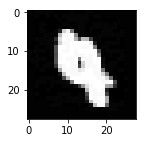

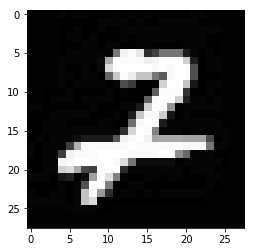

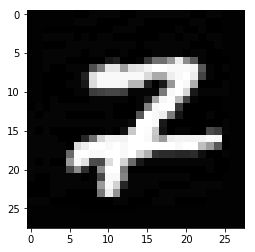

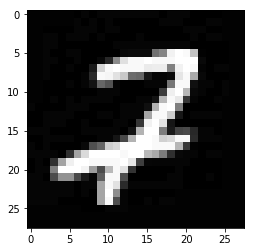

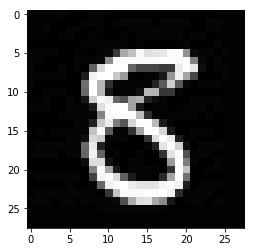

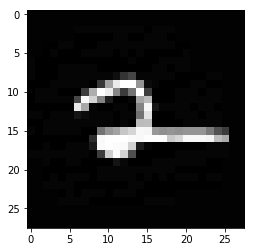

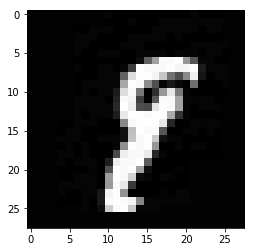

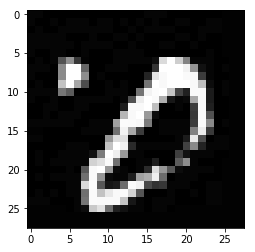

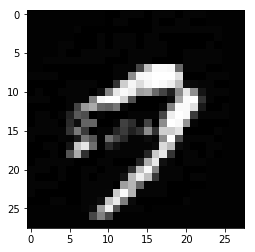

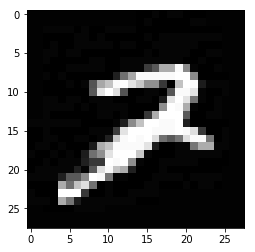

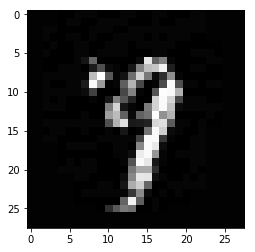

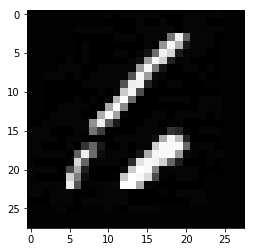

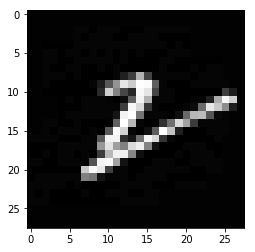

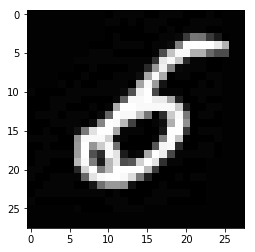

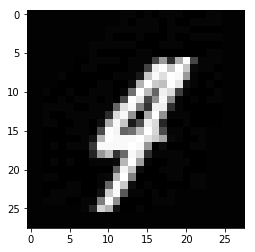

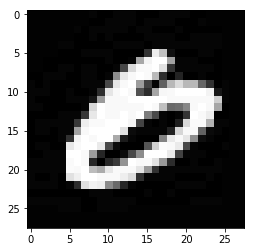

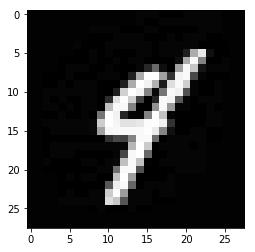

IndexError: index 17 is out of bounds for axis 0 with size 17

In [64]:

plt.figure(figsize=(2, 2))
for i in range(30):
    plt.imshow(fgm[i].reshape(28, 28), cmap='gray')
    plt.show()

In [ ]:
clean[]

### Save background, clean and noised input for subset scanning test

In [ ]:
x_test.shape

In [46]:
#np.save('../ICLR/data/mnist_bg_7000.npy', x_test[:7000])
#np.save('../ICLR/data/mnist_clean_1500.npy', x_test[7000:8500])
np.save('../ICLR/data/mnist_other_clean.npy', x_test[8500:])

In [40]:
np.save('../ICLR/data/fmnist_class_9.npy', x_test[class_9])

### Save only noised images that success on the attack

In [18]:
for noised, name in zip([x_test_adv_df], ['DF']):
    x_test_adv_pred = np.argmax(classifier_model.predict(noised), axis=1)
    nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[8500:], axis=1))
    mask_correct = x_test_adv_pred != np.argmax(y_test[8500:], axis=1)
    noised_images = noised[mask_correct]
    print('*'*10)
    print("Adversarial test data (first 1500 images) for {}:".format(name))
    print("Correctly classified: {}".format(nb_correct_adv_pred))
    print("Incorrectly classified: {}".format(1500 - nb_correct_adv_pred))
    np.save('../ICLR/data/np_fmnist_df_cnn_keras.npy', noised_images)
    print(noised_images.shape)

**********
Adversarial test data (first 1500 images) for DF:
Correctly classified: 341
Incorrectly classified: 1159
(1159, 28, 28, 1)


In [25]:
np.load('../ICLR/data/np_fashion_cw_cnn_keras.npy').shape 

(1414, 28, 28, 1)